In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importación e Instalación de paquetes necesarias

In [2]:
#Instalación de dependencias
!pip install transformers datasets torch sklearn pandas matplotlib

#Importación de librerías
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW
from tqdm import tqdm

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


#Configuraciones iniciales

In [3]:
#Configuración inicial
MODEL_NAME = 'roberta-base'
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 3
PATIENCE = 1  # Para early stopping
THRESHOLD = 0.5  # Umbral para clasificación
PATH_TO_DATA_TRAIN = '/content/drive/MyDrive/RAG Maria/Toxic Comments/train.csv/train.csv'
PATH_TO_DATA_TEST = '/content/drive/MyDrive/RAG Maria/Toxic Comments/test.csv/test.csv'
PATH_TO_DATA_TEST_LABELS = '/content/drive/MyDrive/RAG Maria/Toxic Comments/test_labels.csv/test_labels.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clase personalizada para los datasets

In [4]:
#Clase Dataset personalizada
class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            max_length=MAX_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)

        return item

In [5]:
#Carga de datos de ejemplo (Toxic Comments de Kaggle)
df = pd.read_csv(PATH_TO_DATA_TRAIN)
texts = df['comment_text'].values
labels = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Split de datos
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Tokenizador
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

# Creación de datasets
train_dataset = MultiLabelDataset(train_texts, train_labels, tokenizer)
val_dataset = MultiLabelDataset(val_texts, val_labels, tokenizer)

#%% Modelo
model = RobertaForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=labels.shape[1],
    problem_type="multi_label_classification"
).to(device)

#%% Configuración de entrenamiento
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = BCEWithLogitsLoss()

# Early stopping
best_val_loss = float('inf')
patience_counter = 0

# Historial de métricas
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


<Axes: >

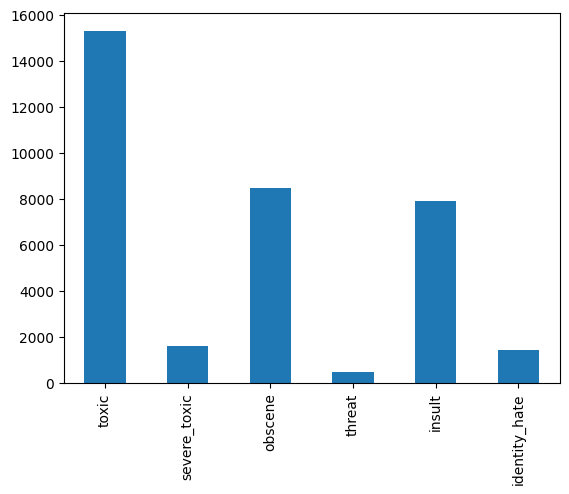

In [7]:
df.iloc[:,2:].sum().plot(kind='bar')

#Entrenamiento del modelo

In [8]:
# Función de entrenamiento
def train_epoch(model, dataloader):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.sigmoid(logits).cpu().detach().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    all_preds = np.array(all_preds) > THRESHOLD
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy

#%% Función de validación
def eval_epoch(model, dataloader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            preds = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    all_preds = np.array(all_preds) > THRESHOLD
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy

In [9]:
#%% Entrenamiento con early stopping
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = eval_epoch(model, val_loader)

    # Actualizar historial
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    # Mostrar métricas
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("\nEarly stopping triggered!")
            model.load_state_dict(torch.load('best_model.pt'))
            break


Epoch 1/3


Validating: 100%|██████████| 1995/1995 [02:07<00:00, 15.68it/s]


Train Loss: 0.0484 | Val Loss: 0.0406
Train Acc: 0.9194 | Val Acc: 0.9205

Epoch 2/3


Validating: 100%|██████████| 1995/1995 [02:05<00:00, 15.87it/s]


Train Loss: 0.0363 | Val Loss: 0.0389
Train Acc: 0.9296 | Val Acc: 0.9254

Epoch 3/3


Validating: 100%|██████████| 1995/1995 [02:06<00:00, 15.78it/s]


Train Loss: 0.0309 | Val Loss: 0.0402
Train Acc: 0.9371 | Val Acc: 0.9267

Early stopping triggered!


## Visuaización de las métricas en entrenamiento

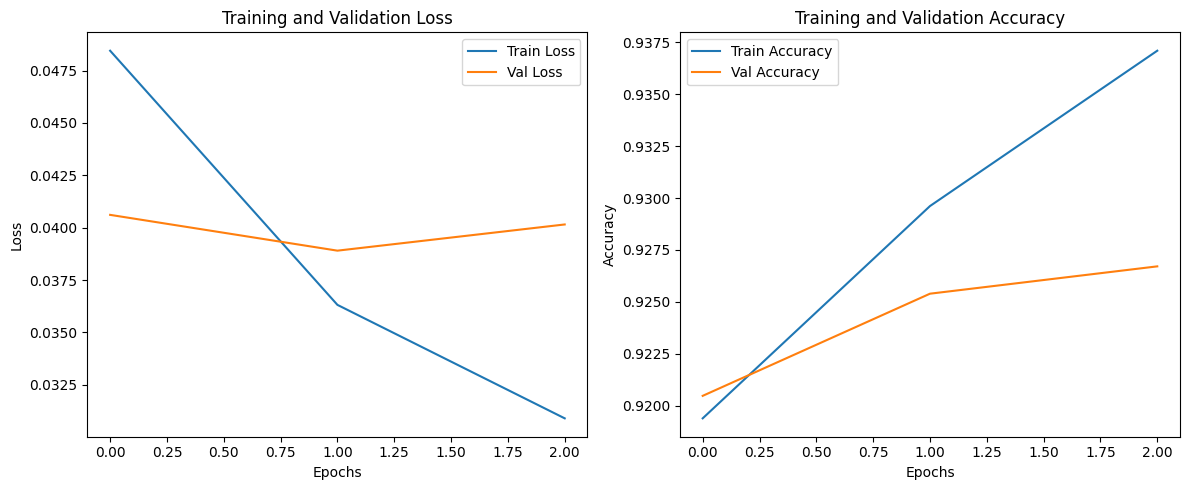

In [10]:
#%% Visualización de métricas
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#Prueba del Modelo(Testing)

In [11]:
#%% Evaluación final
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            preds = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Convertir a etiquetas binarias
    binary_preds = all_preds > THRESHOLD

    # Calcular métricas
    accuracy = accuracy_score(all_labels, binary_preds)
    roc_auc = roc_auc_score(all_labels, all_preds, average='macro')
    report = classification_report(all_labels, binary_preds, target_names=df.columns[2:])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(report)

    return binary_preds, all_labels

In [12]:
df_test = pd.read_csv(PATH_TO_DATA_TEST)
df_test_labels = pd.read_csv(PATH_TO_DATA_TEST_LABELS)

df_test = df_test.merge(df_test_labels, on='id')

#Elimino las filas donde los labels son -1
mask = (df_test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] != -1).all(axis=1)
df_test = df_test[mask].reset_index(drop = True)

texts = df['comment_text'].values
labels = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Split de datos
test_texts, _, test_labels, _ = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

test_dataset = MultiLabelDataset(test_texts, test_labels, tokenizer)

# Ejecutar evaluación
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
predictions, true_labels = evaluate_model(model, test_loader)

#%% Guardar modelo para uso futuro
model.save_pretrained("fine_tuned_roberta")
tokenizer.save_pretrained("fine_tuned_roberta")

Evaluating: 100%|██████████| 7979/7979 [08:24<00:00, 15.81it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Accuracy: 0.9400
ROC AUC: 0.9949

Classification Report:
               precision    recall  f1-score   support

        toxic       0.87      0.90      0.89     12238
 severe_toxic       0.70      0.24      0.36      1274
      obscene       0.81      0.94      0.87      6734
       threat       0.79      0.29      0.42       404
       insult       0.74      0.90      0.81      6263
identity_hate       0.63      0.71      0.67      1111

    micro avg       0.81      0.86      0.84     28024
    macro avg       0.76      0.66      0.67     28024
 weighted avg       0.81      0.86      0.83     28024
  samples avg       0.08      0.08      0.08     28024



('fine_tuned_roberta/tokenizer_config.json',
 'fine_tuned_roberta/special_tokens_map.json',
 'fine_tuned_roberta/vocab.json',
 'fine_tuned_roberta/merges.txt',
 'fine_tuned_roberta/added_tokens.json')